# **Import necessary libraries**

In [44]:
import numpy as np
from numpy.fft import fft, ifft
import cmath
import time
from matplotlib import pyplot as plt

# **FFT part**

In [99]:
class FFT:
    def __init__(self, n, q):
        #Input data: n(integer), q(integer)
        #n is the degree of polynomial, q is the modulo
        self.degree = n
        self.modulo = q
        self.omega = np.exp(2*np.pi*1j/n) #n-th primitive root
        self.psi = np.exp(np.pi*1j/n) #2n-th primitive root
        
    def encode(self, polynomial):
        #Input data: polynomial(ndarray)
        #To utilize FFT to polynomial multiplication, we should expand polynomial to degree 2n
        n = self.degree
        result = np.pad(polynomial, (0, n), 'constant')
        return result
    
    def decode(self, polynomial):
        #input data: polynomial(ndarray)
        #This polynomial has degree 2n
        n = self.degree
        q = self.modulo
        result = np.zeros(n, dtype=np.complex_)
        for i in range(0, n):
            result[i] = polynomial[i] - polynomial[n+i]
        return result
    
    def fft(self, f, omega):
        #Input data: f(ndarray), omega(complex number)
        #f is a polynomial, omega is the n-th primitive root
        n = len(f)
        if n == 1:
            return f
        else:
            f_even = self.fft(f[0::2], omega ** 2)
            f_odd = self.fft(f[1::2], omega ** 2)
            g = np.zeros(n, dtype=np.complex_)
            for i in range(n//2):
                g[i] = (f_even[i] + omega ** i * f_odd[i]) 
                g[i + n//2] = (f_even[i] - omega ** i * f_odd[i])
            return g
        
    def ifft(self, g, omega_inv):
        #Input data: g(ndarray), omega_inv(complex number)
        n = len(g)
        if n == 1:
            return g
        else:
            g_even = self.ifft(g[0::2], omega_inv ** 2)
            g_odd = self.ifft(g[1::2], omega_inv ** 2)
            f = np.zeros(n, dtype=np.complex_)
            for i in range(n//2):
                f[i] = (g_even[i] + omega_inv ** i * g_odd[i]) / 2
                f[i + n//2] = (g_even[i] - omega_inv ** i * g_odd[i]) / 2
            return f
        
    def multiply(self, f, g):
        # Compute the degree of the product polynomial
        deg_f = len(f) - 1
        deg_g = len(g) - 1
        deg_prod = deg_f + deg_g

        # Choose the smallest power of 2 greater than deg_prod
        n = 2**int(np.ceil(np.log2(deg_prod+1)))

        # Pad f and g with zeros up to length n
        f_padded = np.pad(f, (0, n - len(f)), mode='constant')
        g_padded = np.pad(g, (0, n - len(g)), mode='constant')

        # Compute the FFT of f and g
        omega = np.exp(-2 * np.pi * 1j / n)
        fft_f = self.fft(f_padded, omega)
        fft_g = self.fft(g_padded, omega)

        # Compute the pointwise product of the Fourier coefficients
        fft_prod = fft_f * fft_g

        # Compute the IFFT of the product
        omega_inv = np.exp(2 * np.pi * 1j / n)
        prod_coeffs = np.real(self.ifft(fft_prod, omega_inv)[:deg_prod+1])

        return prod_coeffs
 
def mul_fft(p1, p2):
    """Multiply two polynomials.
 
    p1 and p2 are arrays of coefficients in degree-increasing order.
    """
    deg1 = p1.shape[0] - 1
    deg2 = p1.shape[0] - 1
    # Would be 2*(deg1 + deg2) + 1, but the next-power-of-2 handles the +1
    total_num_pts = 2 * (deg1 + deg2)
    next_power_of_2 = 1 << (total_num_pts - 1).bit_length()
 
    ff_p1 = fft(np.pad(p1, (0, next_power_of_2 - p1.shape[0])))
    ff_p2 = fft(np.pad(p2, (0, next_power_of_2 - p2.shape[0])))
    product = ff_p1 * ff_p2
    inverted = ifft(product)
    rounded = np.round(np.real(inverted)).astype(np.int32)
    return np.trim_zeros(rounded, trim='b')

def decode(f):
    k = len(f)//2 #k = n-1
    result = f[:k+1]
    for i in range(k):
        result[i] -= f[i+k+1]
    return result
    
    
    





In [97]:
n=8
q=17
test = FFT(n, q)
f = np.array([0,1,2,3,5,6,8,7])
g = np.array([3,4,2,1,1,2,3,4])
h = mul_fft(f,g)
i = decode(h)
h, i

(array([-71, -52, -44, -42, -30,  -6,  37,  80,  71,  55,  54,  61,  62,
         53,  28]),
 array([-71, -52, -44, -42, -30,  -6,  37,  80]))

In [35]:
n=8
q=17
test = FFT(n, q)
f = np.array([0,1,2,3,4,5,6,7])
f_fft = test.fft(f, np.exp(-2*np.pi*1j/n))
f_ifft = test.ifft(f_fft, np.exp(2*np.pi*1j/n))
print(f, f_fft, f_ifft, sep="\n")

[0 1 2 3 4 5 6 7]
[28.+0.j         -4.+9.65685425j -4.+4.j         -4.+1.65685425j
 -4.+0.j         -4.-1.65685425j -4.-4.j         -4.-9.65685425j]
[0.+0.00000000e+00j 1.-2.22044605e-16j 2.+0.00000000e+00j
 3.+2.22044605e-16j 4.+0.00000000e+00j 5.+2.22044605e-16j
 6.+0.00000000e+00j 7.-2.22044605e-16j]


# **NTT part**

In [39]:
def ntt(f, omega, modulus):
    """Number Theoretic Transform of f using omega as the primitive root of unity."""
    n = len(f)
    if n == 1:
        return f
    else:
        f_even = ntt(f[0::2], omega ** 2 % modulus, modulus)
        f_odd = ntt(f[1::2], omega ** 2 % modulus, modulus)
        g = np.zeros(n, dtype=np.int64)
        for i in range(n//2):
            g[i] = (f_even[i] + omega ** i % modulus * f_odd[i]) % modulus
            g[i + n//2] = (f_even[i] - omega ** i % modulus * f_odd[i]) % modulus
        return g

def inverse_ntt(g, omega_inv, modulus):
    """Inverse Number Theoretic Transform of g using omega_inv as the inverse of the primitive root of unity."""
    n = len(g)
    if n == 1:
        return g
    else:
        g_even = inverse_ntt(g[0::2], omega_inv ** 2 % modulus, modulus)
        g_odd = inverse_ntt(g[1::2], omega_inv ** 2 % modulus, modulus)
        f = np.zeros(n, dtype=np.int64)
        for i in range(n//2):
            f[i] = (g_even[i] + omega_inv ** i % modulus * g_odd[i]) % modulus
            f[i + n//2] = (g_even[i] - omega_inv ** i % modulus * g_odd[i]) % modulus
        return f

def encode(f, psi, q):
    n = len(f)
    result = np.zeros(n)
    for i in range(0, n):
        factor = (psi**i)%q
        result[i] = (f[i]*factor)%q
    return result
        
def decode(f, psi_inverse, q):
    n = len(f)
    result = np.zeros(n)
    
    for i in range(0, n):
        factor = (psi_inverse**i)%q
        result[i] = (f[i]*factor)%q
    return result

def convolution(f, g):
    n = len(f)
    result = np.zeros(n)
    for i in range(0, n):
        result[i] = f[i]*g[i]
    return result
        
def find_psi(q, n):
    generator = 0
    test_value = 2
    while generator == 0:
        if (test_value**(2*n))%q != 1: #Does test_value is a 2n root of unity?
            test_value += 1
            continue
        else:
            pass #Yes, test_value is a 2n root of unity.
            
        test = 0 #Test for 2, 3, ..., 2n-1
        for i in range(2, 2*n):
            if (test_value**i)%q == 1:
                test = 1 #test_value is not the 2n-primitive root of unity
                continue
            else:
                pass
            
        if test == 1: #For doing next test
            test_value += 1
            continue
        else:
            pass
        
        generator = test_value
            
    return generator

def find_q(n):
    result = 2*n + 1 #Initial value
    
    while True:
        prime = 0
        for i in range(2, result):
            if result%i == 0:
                prime = 1
                break
            else:
                pass
        
        if prime == 1:
            result += 2*n
            continue
        else:
            break
            
    return result


# **Rosowski**

In [38]:
def circulant(f, A, b):
    #Input data: f(complex number), A(list of lists), b(list)
    #A is f-circulant matrix, b is a vector
    
    #Setting
    n = len(A)
    
    if n == 2:
        result = np.multiply(A, b)
        return result
    else:
        #Step 1)Calculate A1 and A2, b1 and b2
        A1 = A[: n//2, : n//2]
        A2 = A[: n//2, n//2:]
        
        b1 = b[: n//2]
        b2 = b[n//2:]
        
        #Step 2)Calculate A_M1 and A_M2, b_M1 and b_N2
        A_M1 = A1 + cmath.sqrt(f)*A2
        A_M2 = A1 - cmath.sqrt(f)*A2
        
        b_M1 = b1 + cmath.sqrt(f)*b2
        b_M2 = b1 - cmath.sqrt(f)*b2
        
        #Step 3)Calculate M1 and M2
        M1 = circulant(cmath.sqrt(f), A_M1, b_M1)
        M2 = circulant(-cmath.sqrt(f), A_M2, b_M2)
        
        #Step 4)Calculate result, c
        c1 = (0.5)*(M1 + M2)
        c2 = (0.5)*(1/cmath.sqrt(f))*(M1 - M2)
        
        c = np.concatenate((c1, c2))
        
        return c
    
def circulant1(A, b):
    #Input data: f(complex number), A(list of lists), b(list)
    #A is f-circulant matrix, b is a vector
    
    #Setting
    n = len(A)
    
    if n == 2:
        result = np.multiply(A, b)
        return result
    else:
        #Step 1)Calculate A1 and A2, b1 and b2
        A1 = A[: n//2, : n//2]
        A2 = A[: n//2, n//2:]
        
        b1 = b[: n//2]
        b2 = b[n//2:]
        
        #Step 2)Calculate A_M1 and A_M2, b_M1 and b_N2
        A_M1 = A1 + A2
        A_M2 = A1 - A2
        
        b_M1 = b1 + b2
        b_M2 = b1 - b2
        
        #Step 3)Calculate M1 and M2
        M1 = circulant1(A_M1, b_M1)
        M2 = circulant1(A_M2, b_M2)
        
        #Step 4)Calculate result, c
        c1 = (0.5)*(M1 + M2)
        c2 = (0.5)*(M1 - M2)
        
        c = np.concatenate((c1, c2))
        
        return c

    
def PTC(f):
    #Polynomial to circulant matrix
    #Input data: f(array)
    #f is a polynomial
    n = len(f)
    result = np.zeros((n, n))
    
    for i in range(0, n): #Select column
        for j in range(0, n): #Select row
            if j >= i:
                result[j][i] = f[j-i]
            else:
                result[j][i] = -f[n-i+j]
    return result

    
        
    
    
    

In [80]:
c = np.array([0,1,2,3])
A = PTC(c)
b = np.array([3,4,2,1])
B = circulant(-1, A, b)
A, B

(array([[ 0., -3., -2., -1.],
        [ 1.,  0., -3., -2.],
        [ 2.,  1.,  0., -3.],
        [ 3.,  2.,  1.,  0.]]),
 array([ 11.+0.j,  -5.+0.j, -17.-0.j, -17.-0.j]))

# **Naive part**

In [11]:
def naive(f, g):
    n = len(f)
    result = np.zeros(2*n-1)
    for i in range(0, n):
        for j in range(0, n):
            result[i+j] += f[i]*g[j]
    return result

# **Experiment**

In [12]:
degree = []
time_naive = []
time_ntt = []
time_circulant = []
for i in range(3, 15):
    n = 2**i #degree
    degree.append(n)
    
    #Generate polynomial
    f = np.zeros(n)
    g = np.zeros(n)
    for j in range(0, n):
        f[j] = j%17
        g[j] = (n-j)%17
    
    #Naive
    start_naive = time.time()
    h1 = naive(f, g)
    end_naive = time.time()
    
    time_naive.append(end_naive - start_naive)
    
    #NTT
    start_ntt = time.time()
    f_encode = encode(f, )
    h4 = mul_ntt(f, g, 17)
    end_ntt = time.time()
    
    time_ntt.append(end_ntt - start_ntt)
    
    #Circulant
    A = PTC(f)
    start_circulant = time.time()
    h3 = circulant1(A, g)
    end_circulant = time.time()
    
    time_circulant.append(end_circulant - start_circulant)
    
print("end")

TypeError: encode() missing 2 required positional arguments: 'psi' and 'q'

In [113]:
time_naive, time_fft, time_ntt, time_circulant

([0.0,
  0.0,
  0.0005786418914794922,
  0.0016324520111083984,
  0.00650334358215332,
  0.028807640075683594,
  0.15181684494018555,
  0.8494007587432861,
  2.856165885925293,
  11.472538709640503,
  46.34545135498047,
  187.0524342060089],
 [0.0015625953674316406,
  0.0,
  0.000720977783203125,
  0.0,
  0.0012881755828857422,
  0.00099945068359375,
  0.001997232437133789,
  0.007630586624145508,
  0.014172792434692383,
  0.02513861656188965,
  0.05892014503479004,
  0.09339380264282227],
 [0.009544849395751953,
  0.0010001659393310547,
  0.0009992122650146484,
  0.0019991397857666016,
  0.003574371337890625,
  0.0076177120208740234,
  0.015635967254638672,
  0.07977819442749023,
  0.1414957046508789,
  0.3498523235321045,
  0.5552384853363037,
  1.3571128845214844],
 [0.0010004043579101562,
  0.0,
  0.0010232925415039062,
  0.0012323856353759766,
  0.00099945068359375,
  0.0020003318786621094,
  0.004999637603759766,
  0.02115774154663086,
  0.07451200485229492,
  0.16653728485107422

In [41]:
#Z[x]/(x^n + 1)
degree = []
time_naive = []
time_ntt = []
time_circulant = []
for i in range(3, 20):
    n = 2**i #degree
    print("Degree ", n, " starts")
    degree.append(n)
    q = find_q(n)
    psi = find_psi(q, n)
    psi_inverse = (psi**(2*n-1))%q
    
    #Generate polynomial
    f = np.zeros(n)
    g = np.zeros(n)
    for j in range(0, n):
        f[j] = j%17
        g[j] = (n-j)%17
        
    #Circulant
    start_circulant = time.time()
    A = PTC(f)
    h3 = circulant(-1, A, g)
    end_circulant = time.time()
    
    time_circulant.append(end_circulant - start_circulant)
    
    #Naive
    start_naive = time.time()
    h1 = naive(f, g)
    end_naive = time.time()
    
    time_naive.append(end_naive - start_naive)
    
    #NTT
    start_ntt = time.time()
    f_encode = encode(f, psi, q)
    g_encode = encode(g, psi, q)
    f_ntt = ntt(f_encode, (psi**2)%q, q)
    g_ntt = ntt(g_encode, (psi**2)%q, q)
    h2 = convolution(f_ntt, g_ntt)
    h22 = inverse_ntt(h2, (psi_inverse**2)%q, q)
    h222 = decode(h22, psi_inverse, q)
    end_ntt = time.time()
    
    time_ntt.append(end_ntt - start_ntt)
    
print("end")

Degree  8  starts
Degree  16  starts
Degree  32  starts
Degree  64  starts
Degree  128  starts
Degree  256  starts
Degree  512  starts
Degree  1024  starts
Degree  2048  starts
Degree  4096  starts
Degree  8192  starts
Degree  16384  starts
Degree  32768  starts
Degree  65536  starts


MemoryError: Unable to allocate 16.0 GiB for an array with shape (32768, 32768) and data type complex128

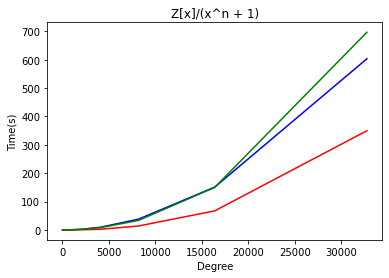

In [47]:
plt.plot(degree, time_naive, 'b', label = 'Naive')
plt.plot(degree, time_ntt, 'r', label = 'NTT')
plt.plot(degree, time_circulant, 'g', label = 'Circulant')
plt.title("Z[x]/(x^n + 1)")
plt.xlabel("Degree")
plt.ylabel("Time(s)")
plt.show()

In [50]:
#Z[x]/(x^n - 1)
degree2 = []
time_naive2 = []
time_ntt2 = []
time_circulant2 = []
for i in range(3, 20):
    n = 2**i #degree
    print("Degree ", n, " starts")
    degree2.append(n)
    q = find_q(n)
    psi = find_psi(q, n)
    psi_inverse = (psi**(2*n-1))%q
    
    #Generate polynomial
    f = np.zeros(n)
    g = np.zeros(n)
    for j in range(0, n):
        f[j] = j%17
        g[j] = (n-j)%17
        
    #Circulant
    start_circulant = time.time()
    A = PTC(f)
    h3 = circulant1(A, g)
    end_circulant = time.time()
    
    time_circulant2.append(end_circulant - start_circulant)
    
    #Naive
    start_naive = time.time()
    h1 = naive(f, g)
    end_naive = time.time()
    
    time_naive2.append(end_naive - start_naive)
    
    #NTT
    start_ntt = time.time()
    f_ntt = ntt(f_encode, (psi**2)%q, q)
    g_ntt = ntt(g_encode, (psi**2)%q, q)
    h2 = convolution(f_ntt, g_ntt)
    h22 = inverse_ntt(h2, (psi_inverse**2)%q, q)
    end_ntt = time.time()
    
    time_ntt2.append(end_ntt - start_ntt)
    
print("end")

Degree  8  starts
Degree  16  starts
Degree  32  starts
Degree  64  starts
Degree  128  starts
Degree  256  starts
Degree  512  starts
Degree  1024  starts
Degree  2048  starts
Degree  4096  starts
Degree  8192  starts
Degree  16384  starts
Degree  32768  starts
Degree  65536  starts


MemoryError: Unable to allocate 32.0 GiB for an array with shape (65536, 65536) and data type float64

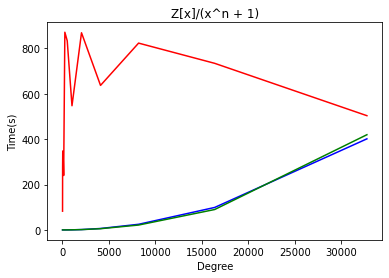

In [57]:
plt.plot(degree2, time_naive2, 'b', label = 'Naive')
plt.plot(degree2, time_ntt2, 'r', label = 'NTT')
plt.plot(degree2, time_circulant2, 'g', label = 'Circulant')
plt.title("Z[x]/(x^n - 1)")
plt.xlabel("Degree")
plt.ylabel("Time(s)")
plt.show()

In [59]:
time_ntt2

[82.49224138259888,
 276.52617859840393,
 347.7648227214813,
 339.91208004951477,
 239.78269505500793,
 870.687246799469,
 833.1310286521912,
 546.9512968063354,
 868.3787639141083,
 636.5668683052063,
 822.8121597766876,
 733.7722725868225,
 503.1770143508911]